In [ ]:
import urllib.request
import matplotlib.image as mpimg
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

# **Color Histogram**

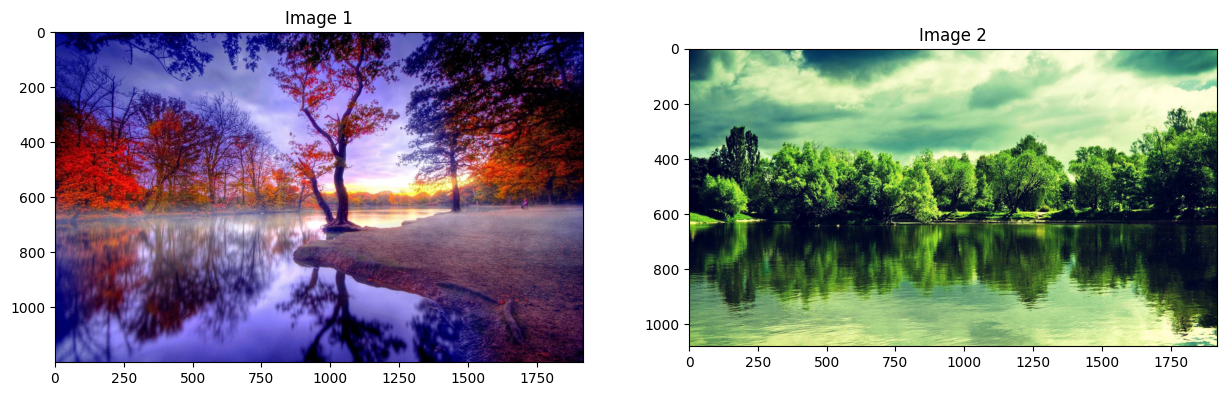

In [ ]:
# color histogram is best shown when comparing 2 images, we download 2 images from the web
urllib.request.urlretrieve('https://wallpapers.com/images/hd/autumn-fall-scenery-sunset-1l46cha0qzfg4n4d.webp', 'image1.jpg')
image1 = mpimg.imread('image1.jpg')
urllib.request.urlretrieve('https://wallpapers.com/images/hd/tree-on-green-lake-1519g7y2yexhnyvl.jpg', 'image2.jpg')
image2 = mpimg.imread('image2.jpg')

# plot the 2 downloaded image together
plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Image 2')

plt.show()

In [ ]:
# calculate the histogram data based on individual color channel for 2 images
red_hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
green_hist1 = cv2.calcHist([image1], [1], None, [256], [0, 256])
blue_hist1 = cv2.calcHist([image1], [2], None, [256], [0, 256])

red_hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
green_hist2 = cv2.calcHist([image2], [1], None, [256], [0, 256])
blue_hist2 = cv2.calcHist([image2], [2], None, [256], [0, 256])

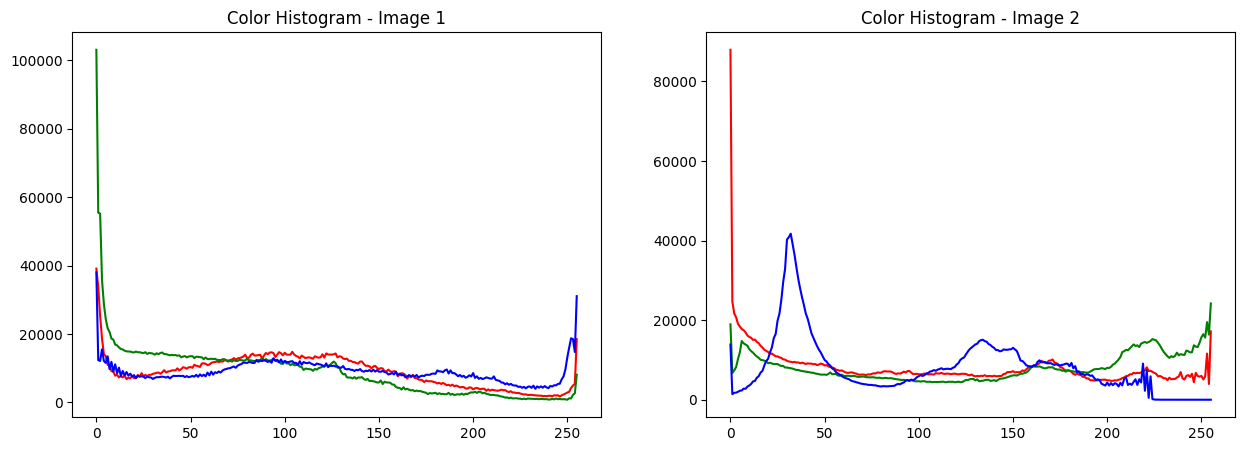

In [ ]:
# plot the RGB channels together for each image
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(red_hist1, c = 'r')
plt.plot(green_hist1, c = 'g')
plt.plot(blue_hist1, c = 'b')
plt.title('Color Histogram - Image 1')

plt.subplot(1, 2, 2)
plt.plot(red_hist2, c = 'r')
plt.plot(green_hist2, c = 'g')
plt.plot(blue_hist2, c = 'b')
plt.title('Color Histogram - Image 2')

plt.show()

# **Dimensionality Reduction - PCA**

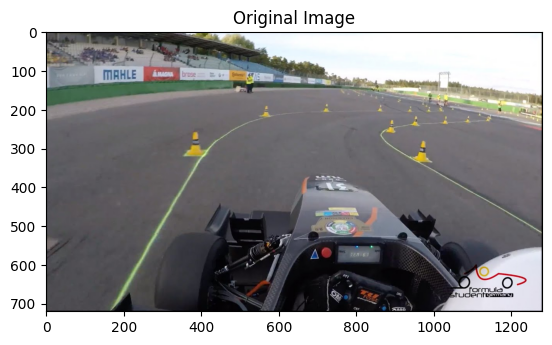

(720, 1280, 3)

In [ ]:
# new image for parts below for better edge detection application (track limits)
urllib.request.urlretrieve('https://i.ytimg.com/vi/M6kTHIfS-6A/maxresdefault.jpg', 'image3.jpg')
# plot original image
img = mpimg.imread('image3.jpg')
plt.imshow(img)
plt.title('Original Image')
plt.show()
img.shape #original image data dimension

In [ ]:
n = 0
var = 0
# hyperparameter tuning to find optimal n_component to achieve at least 98% variance explained
while var < 0.98:
  n += 1
  pca = PCA(n_components = n)

  pca_red = pca.fit(img[:, :, 0] / 255) #normalize RGB channels for better PCA result
  pca_green = pca.fit(img[:, :, 1] / 255)
  pca_blue = pca.fit(img[:, :, 2] / 255)

  var = min(sum(pca_red.explained_variance_ratio_),sum(pca_green.explained_variance_ratio_),sum(pca_blue.explained_variance_ratio_))

# show reduced dimension
print(f'Dimension reduced from 720 x 1280 to 720 x {n}')
print(f'Dimension reduction of {(1 - n/1280)*100:.2f}%')

Dimension reduced from 720 x 1280 to 720 x 54
Dimension reduction of 95.78%


In [ ]:
# apply tuned PCA on normalized RGB channels
red_re = pca_red.transform(img[:, :, 0] / 255)
green_re = pca_green.transform(img[:, :, 1] / 255)
blue_re = pca_blue.transform(img[:, :, 2] / 255)

In [ ]:
# reconstruct the RGB channels
red_recon = pca_red.inverse_transform(red_re)
green_recon = pca_green.inverse_transform(green_re)
blue_recon = pca_blue.inverse_transform(blue_re)

# some reconstructed values are outside 0-1, normalize the reconstructed data again for better result
red_recon = (red_recon - np.min(red_recon)) / (np.max(red_recon) - np.min(red_recon))
green_recon = (green_recon - np.min(green_recon)) / (np.max(green_recon) - np.min(green_recon))
blue_recon = (blue_recon - np.min(blue_recon)) / (np.max(blue_recon) - np.min(blue_recon))

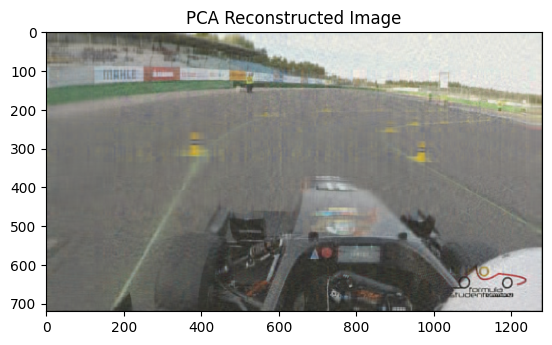

In [ ]:
# combine the reconstructed RGB data back into image
img_recon = np.dstack((red_recon * 255, green_recon * 255, blue_recon * 255))

#plot reconstructed image
plt.imshow(img_recon.astype(np.uint8)) #had a warning with data type when plotting, found suggestion on stackflow
plt.title('PCA Reconstructed Image')
plt.show()

# **Greyscaling**

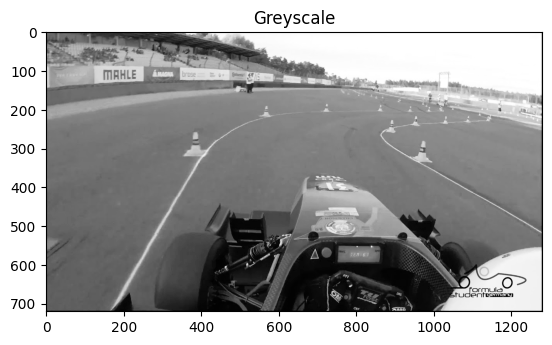

(720, 1280)

In [ ]:
img_grey = np.dot(img, [0.299, 0.587, 0.114]) # apply weights to RGB channels to get grescaled data
# plot greyscaled image
plt.imshow(img_grey, cmap='Greys_r') #use grey color mapping to show the greyscaled image in matlibplot
plt.title('Greyscale')
plt.show()
img_grey.shape # show reduced dimension

# **Intensity Threshold**

In [ ]:
# write function for intensity threshold
def intensity_threshold(image, cutoff = 128):
  _image = image.copy() # I want to show desired features in black, and these features are currently in light colors
  image[_image > cutoff] = 0 # apply the threshold
  image[_image <= cutoff] = 255
  return image

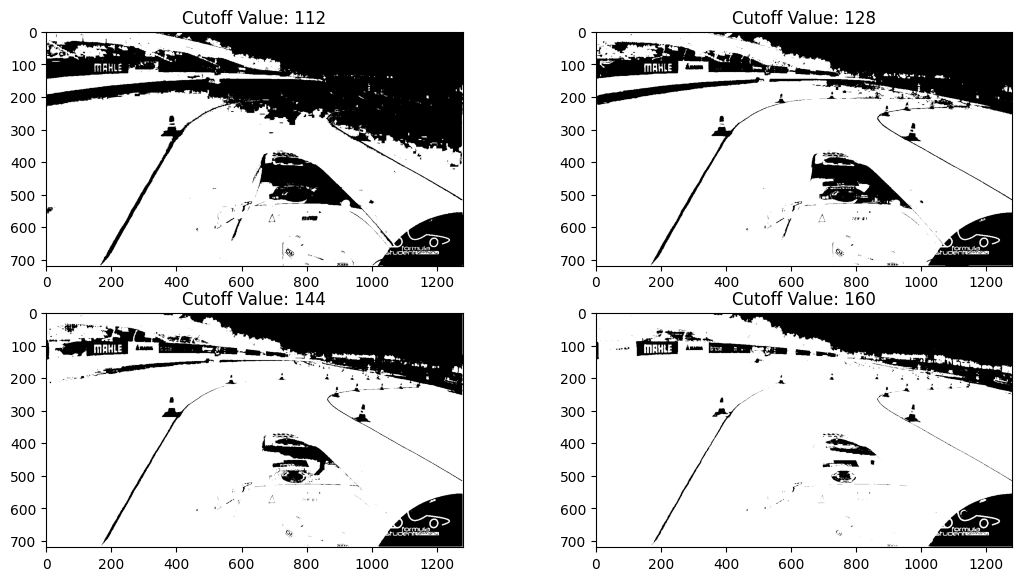

In [ ]:
# plot subplots for different threshold values for comparison using the function above
plt.figure(figsize = (13, 14))
gs = gridspec.GridSpec(4, 2)

for i, cutoff in enumerate([112, 128, 144, 160]):
  img_threshold = img_grey.copy()
  ax = plt.subplot(gs[i])
  plt.imshow(intensity_threshold(img_threshold, cutoff), cmap='Greys_r')
  ax.set_title(f'Cutoff Value: {cutoff}')

# **Edge detection**

In [ ]:
# used canny edge detection with opencv, tested different threshold for the canny algorithm (trade-off with noise and detail)
plt.figure(figsize = (13, 14))
gs = gridspec.GridSpec(4, 2)

for i, [low, up] in enumerate([[20, 50], [50, 150], [20, 100], [100, 150]]):
  edge_img = cv2.Canny(img.astype(np.uint8), threshold1 = low, threshold2 = up)
  ax = plt.subplot(gs[i])
  plt.imshow(edge_img, cmap='Greys_r')
  ax.set_title(f'Threshold: {low}, {up}')

In [ ]:
# separate plot for presentation use
edge_img = cv2.Canny(img.astype(np.uint8), threshold1 = 50, threshold2 = 150)

plt.imshow(edge_img, cmap='Greys_r')
plt.title('Canny Edge Detection: Threshold of 50, 150')
plt.show()